Currently:
* training the original network (500-500-2000-2) on mnist with tsne loss
* training the original network on a pre-embedded set of 2d points with mse loss
* training a convolution net on a pre-embedded set of 2d points with mse loss

Next:
* check tsne loss on test set for all three models
* if we lower the learning rate in response to test set loss can we acheive lower final loss?
* what architecture allows us to minimize the number of parameters while also minimizing test tsne loss?
* does dropout have an effect on the generalization of any of the models?
* can we "deep dream" a point in 2d space to recover an input that produces it?
* what happens if we permute the input data but use the same joint probabilities?
* what if we instead use P from an unsupervised mid-dimensional representation like an autoencoder or VAE? (e.g., 48D)
* what if we use t-SNE loss as a contributing cost function to an autoencoder?

In [1]:
!nvidia-smi

'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
import os
os.environ['THEANO_FLAGS'] = 'device=gpu1'

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.objectives import categorical_crossentropy
from keras.datasets import mnist

C:\Users\stepa\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
batch_size = 5000

%time (X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

Wall time: 290 ms
60000 train samples
10000 test samples


In [5]:
def Hbeta(D, beta):
    P = np.exp(-D * beta)
    sumP = np.sum(P)
    H = np.log(sumP) + beta * np.sum(np.multiply(D, P)) / sumP
    P = P / sumP
    return H, P

def x2p(X, u=15, tol=1e-4, print_iter=500, max_tries=50, verbose=0):
    # Initialize some variables
    n = X.shape[0]                     # number of instances
    P = np.zeros((n, n))               # empty probability matrix
    beta = np.ones(n)                  # empty precision vector
    logU = np.log(u)                   # log of perplexity (= entropy)
    
    # Compute pairwise distances
    if verbose > 0: print('Computing pairwise distances...')
    sum_X = np.sum(np.square(X), axis=1)
    # note: translating sum_X' from matlab to numpy means using reshape to add a dimension
    D = sum_X + sum_X[:,None] + -2 * X.dot(X.T)

    # Run over all datapoints
    if verbose > 0: print('Computing P-values...')
    for i in range(n):
        
        if verbose > 1 and print_iter and i % print_iter == 0:
            print('Computed P-values {} of {} datapoints...'.format(i, n))
        
        # Set minimum and maximum values for precision
        betamin = float('-inf')
        betamax = float('+inf')
        
        # Compute the Gaussian kernel and entropy for the current precision
        indices = np.concatenate((np.arange(0, i), np.arange(i + 1, n)))
        Di = D[i, indices]
        H, thisP = Hbeta(Di, beta[i])
        
        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while abs(Hdiff) > tol and tries < max_tries:
            
            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i]
                if np.isinf(betamax):
                    beta[i] *= 2
                else:
                    beta[i] = (beta[i] + betamax) / 2
            else:
                betamax = beta[i]
                if np.isinf(betamin):
                    beta[i] /= 2
                else:
                    beta[i] = (beta[i] + betamin) / 2
            
            # Recompute the values
            H, thisP = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1
        
        # Set the final row of P
        P[i, indices] = thisP
        
    if verbose > 0: 
        print('Mean value of sigma: {}'.format(np.mean(np.sqrt(1 / beta))))
        print('Minimum value of sigma: {}'.format(np.min(np.sqrt(1 / beta))))
        print('Maximum value of sigma: {}'.format(np.max(np.sqrt(1 / beta))))
    
    return P, beta

def compute_joint_probabilities(samples, batch_size=5000, d=2, perplexity=30, tol=1e-5, verbose=0):
    v = d - 1
    
    # Initialize some variables
    n = samples.shape[0]
    batch_size = min(batch_size, n)
    
    # Precompute joint probabilities for all batches
    if verbose > 0: print('Precomputing P-values...')
    batch_count = int(n / batch_size)
    P = np.zeros((batch_count, batch_size, batch_size))
    for i, start in enumerate(range(0, n - batch_size + 1, batch_size)):   
        curX = samples[start:start+batch_size]                   # select batch
        P[i], beta = x2p(curX, perplexity, tol, verbose=verbose) # compute affinities using fixed perplexity
        P[i][np.isnan(P[i])] = 0                                 # make sure we don't have NaN's
        P[i] = (P[i] + P[i].T) # / 2                             # make symmetric
        P[i] = P[i] / P[i].sum()                                 # obtain estimation of joint probabilities
        P[i] = np.maximum(P[i], np.finfo(P[i].dtype).eps)

    return P

In [6]:
#%time P = compute_joint_probabilities(X_train, batch_size=batch_size, verbose=2)

In [7]:
#%time np.save('P.npy', P)
%time P = np.load('P.npy')

Wall time: 14.7 s


In [8]:
# P is the joint probabilities for this batch (Keras loss functions call this y_true)
# activations is the low-dimensional output (Keras loss functions call this y_pred)
def tsne(P, activations):
#     d = K.shape(activations)[1]
    d = 2 # TODO: should set this automatically, but the above is very slow for some reason
    n = batch_size # TODO: should set this automatically
    v = d - 1.
    eps = K.variable(10e-15) # needs to be at least 10e-8 to get anything after Q /= K.sum(Q)
    sum_act = K.sum(K.square(activations), axis=1)
    Q = K.reshape(sum_act, [-1, 1]) + -2 * K.dot(activations, K.transpose(activations))
    Q = (sum_act + Q) / v
    Q = K.pow(1 + Q, -(v + 1) / 2)
    Q *= K.variable(1 - np.eye(n))
    Q /= K.sum(Q)
    Q = K.maximum(Q, eps)
    C = K.log((P + eps) / (Q + eps))
    C = K.sum(P * C)
    return C

In [9]:
model = Sequential()
model.add(Dense(512, activation='tanh', input_shape=(X_train.shape[1],)))
model.add(Dense(512, activation='tanh'))
model.add(Dense(2048, activation='tanh'))
model.add(Dense(3))
%time model.compile(loss=tsne, optimizer='rmsprop')

Wall time: 318 ms


In [10]:
Y_train = P.reshape(X_train.shape[0], -1)
print(X_train.shape)
print(Y_train.shape)

(60000, 784)
(60000, 5000)


In [11]:
%time model.fit(X_train, Y_train, batch_size=batch_size, shuffle=False, epochs=100)

Epoch 1/100
60000/60000 [==============================] - 9s 143us/step - loss: 3.1991
Epoch 2/100
60000/60000 [==============================] - 3s 48us/step - loss: 2.7625
Epoch 3/100
60000/60000 [==============================] - 3s 49us/step - loss: 2.6304
Epoch 4/100
60000/60000 [==============================] - 3s 48us/step - loss: 2.5066
Epoch 5/100
60000/60000 [==============================] - 3s 48us/step - loss: 2.4085
Epoch 6/100
60000/60000 [==============================] - 3s 49us/step - loss: 2.3373
Epoch 7/100
60000/60000 [==============================] - 3s 49us/step - loss: 2.2828
Epoch 8/100
60000/60000 [==============================] - 3s 49us/step - loss: 2.2181
Epoch 9/100
60000/60000 [==============================] - 3s 48us/step - loss: 2.1814
Epoch 10/100
60000/60000 [==============================] - 3s 48us/step - loss: 2.1543
Epoch 11/100
60000/60000 [==============================] - 3s 48us/step - loss: 2.1032
Epoch 12/100
60000/60000 [==============

60000/60000 [==============================] - 3s 48us/step - loss: 1.5761
Epoch 95/100
60000/60000 [==============================] - 3s 48us/step - loss: 1.5687
Epoch 96/100
60000/60000 [==============================] - 3s 48us/step - loss: 1.5677
Epoch 97/100
60000/60000 [==============================] - 3s 48us/step - loss: 1.5657
Epoch 98/100
60000/60000 [==============================] - 3s 48us/step - loss: 1.5618
Epoch 99/100
60000/60000 [==============================] - 3s 48us/step - loss: 1.5612
Epoch 100/100
60000/60000 [==============================] - 3s 49us/step - loss: 1.5577
Wall time: 4min 56s


In [12]:
predicted = model.predict(X_train)

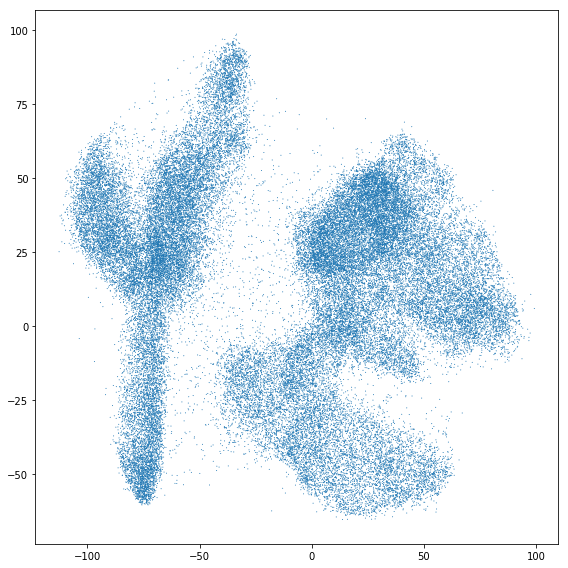

In [13]:
def plot_model(embedding):
    fig = plt.figure(figsize=(8,8))
    plt.scatter(embedding[:,0], embedding[:,1], marker='o', s=1, edgecolor='')
    fig.tight_layout()
    
from matplotlib.lines import Line2D
def plot_differences(embedding, actual, lim=1000):
    fig = plt.figure(figsize=(8,8))
    ax = fig.gca()
    for a, b in zip(embedding, actual)[:lim]:
        ax.add_line(Line2D((a[0], b[0]), (a[1], b[1]), linewidth=1))
    ax.autoscale_view()
    plt.show()
plot_model(predicted)

In [18]:
import ipyvolume as ipv
ipv.quickscatter(predicted[:, 0], predicted[:, 1], predicted[:, 2], size=0.2, marker="sphere")

A Jupyter Widget

In [26]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

%time db = DBSCAN(eps=7, min_samples=100).fit(predicted)
labels = db.labels_
unique_labels = set(labels)
print('Labels %s' % len(unique_labels))
colors = [plt.cm.Spectral(each)[:3] for each in np.linspace(0, 1, len(unique_labels))]
colors = dict(zip(unique_labels, colors))
col = [colors[x] if x != -1 else [0, 0, 0] for x in labels]

ipv.quickscatter(x=predicted[:, 0], y=predicted[:, 1], z=predicted[:, 2], size=0.2, marker="sphere", color=col)

Wall time: 1.97 s
Labels 10


A Jupyter Widget

In [20]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

metric = "euclidean"
linkage = "ward"
knn = kneighbors_graph(predicted, 8)
agg = AgglomerativeClustering(n_clusters=10, linkage=linkage, affinity=metric, connectivity=knn)
%time agg.fit(predicted)
unique_labels = set(agg.labels_)
print('Labels %s' % len(unique_labels))
colors = [plt.cm.Spectral(each)[:3] for each in np.linspace(0, 1, len(unique_labels))]
colors = dict(zip(unique_labels, colors))
col = [colors[x] if x != -1 else [0, 0, 0] for x in agg.labels_]

ipv.quickscatter(x=predicted[:, 0], y=predicted[:, 1], z=predicted[:, 2], size=0.2, marker="sphere", color=col)

Wall time: 6.08 s
Labels 10


A Jupyter Widget

In [17]:
agg=None